## Scalable Retrieval with a Vocabulary Tree

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import os.path as osp

from vocab_tree import *
from utils import *
import src as sc

In [2]:
data_path = osp.join('..','data')
agument_path = osp.join(data_path, 'agument')
categories = ['boy', 'cat', 'car', 'dog', 'girl']
interested_frames = ['start', 'middle', 'quater3']
limit_each_category = 1000
vocab_size = 200
vocab_prefix = 'vocab.pkl'

# load image paths
category_paths = get_image_directories(data_path, categories)
agument_category_paths = get_image_directories(agument_path, categories)
image_paths, image_labels, image_ids = load_images_paths(limit_each_category, category_paths)

In [3]:
N = len(image_paths)# Number of samples to take as training set

## build the vocabulary tree

In [5]:
sampled_descriptor_file = 'sampled_descriptors.pkl'
if not osp.exists(sampled_descriptor_file):
    sc.build_vocabulary(image_paths, vocab_size, sampled_file='sampled_descriptors.pkl')
#------------------------------------------------------------------------------------------------------------
start = t.time()
print("Extracting Features: ...")
with open(sampled_descriptor_file, 'rb') as f:
    features = pickle.load(f)
end = t.time()
print("Time Taken: ", str(round((end - start)/60, 2)))

Extracting Features: ...
Time Taken:  0.14


In [6]:
start = t.time()
print("Constructing Vocabulary Tree ... ")
root = features.mean(axis = 0)
nodes[0] = root
# Do not send the feature array itself but an array of indices into the construct tree function
# This will save memory by a factor of 128, an awesome little trick, why didn't I think it before
featuresIDs = [x for x in range(len(features))]
constructTree(0, featuresIDs, 0, features)
end = t.time()
print("Time Taken: ", str(round((end - start)/60, 2)))
del features

Constructing Vocabulary Tree ... 
Time Taken:  5.81


## Build inverted file index

### add the agument images

In [7]:
agument_paths, agument_labels, agument_ids = load_agument_image_paths(agument_path, image_paths, [2, 1.5])

image_paths = np.concatenate((image_paths, agument_paths), axis=0)
image_labels = np.concatenate((image_labels, agument_labels), axis=0)
image_ids = np.concatenate((image_ids, agument_ids), axis=0)

N = len(image_paths)# Number of samples to take as training set

### create invert file index for all images
### record all tfi-df frequencies for all images

In [8]:
avgDepth = int(avgDepth/len(imagesInLeaves))

start = t.time()
print("Mapping images to leaf nodes of the tree ...")

# build the invert file index
for image_path in image_paths:
    tfidf(image_path)
    
# create all image dictionary
for leafID in imagesInLeaves:
    for img in imagesInLeaves[leafID]:
        if img not in doc:
            doc[img] = {}
        doc[img][leafID] = weight(leafID, N, imagesInLeaves)*(imagesInLeaves[leafID][img])
        
# L1 - normalization
for img in doc:
    s = 0.0
    for leafID in doc[img]:
        s += doc[img][leafID]
    for leafID in doc[img]:
        doc[img][leafID] /= s
end = t.time()
print("Time Taken: ", str(round((end - start)/60, 2)))

Mapping images to leaf nodes of the tree ...
Time Taken:  451.39


## Match sample

Finding Best Matches for each image ...
/Users/pagepeng/Desktop/test.png
['../data/agument/boy/1.5_15707.gif', '../data/boy/15707.gif', '../data/agument/girl/1.5_118813.gif', '../data/agument/girl/1.5_13341.gif']


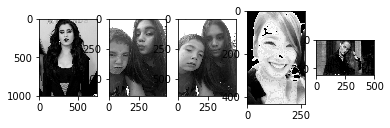

Time Taken:  8.26


In [11]:
print("Finding Best Matches for each image ...")
start = t.time()
dataset_paths = ['/Users/pagepeng/Desktop/test.png']
for path in dataset_paths:
    print(path)
    group = match(path, N, image_paths)
    print(group)
    plt.subplots(1, 5)
    plt.subplot(1, 5, 1)
    plt.imshow(load_gif_gray(path), cmap='gray')
    plt.subplot(1, 5, 2)
    plt.imshow(load_gif_gray(group[0]), cmap='gray')
    plt.subplot(1, 5, 3)
    plt.imshow(load_gif_gray(group[1]), cmap='gray')
    plt.subplot(1, 5, 4)
    plt.imshow(load_gif_gray(group[2]), cmap='gray')
    plt.subplot(1, 5, 5)
    plt.imshow(load_gif_gray(group[3]), cmap='gray')
    plt.show()
        
end = t.time()
print("Time Taken: ", str(round((end - start)/60, 2)))
# print(branches, maxDepth, result/N, ((result/N).sum())/0.04)
#------------------------------------------------------------------------------------------------------------

### persist the vocabulary tree(locally and remotely)

In [10]:
with open('nodes.pkl', 'wb') as f:
    pickle.dump(nodes, f)
with open('tree.pkl', 'wb') as f:
    pickle.dump(tree, f)
with open('imagesInLeaves.pkl', 'wb') as f:
    pickle.dump(imagesInLeaves, f)
with open('doc.pkl', 'wb') as f:
    pickle.dump(doc, f)

In [ ]:
with open('tree.pkl', 'rb') as f:
    tree = pickle.load(f)
with open('imagesInLeaves.pkl', 'rb') as f:
    imagesInLeaves = pickle.load(f)
with open('doc.pkl', 'rb') as f:
    doc = pickle.load(f)

In [ ]:
import vocab_tree
vocab_tree.nodes = nodes
vocab_tree.tree = tree
vocab_tree.imagesInLeaves = imagesInLeaves
vocab_tree.doc = doc

In [ ]:
import requests
import codecs
request_data = {
    'nodes':  codecs.encode(pickle.dumps(nodes), "base64").decode(),
    'tree': codecs.encode(pickle.dumps(tree), "base64").decode(),
    'imagesInLeaves': codecs.encode(pickle.dumps(imagesInLeaves), "base64").decode(),
    'doc': codecs.encode(pickle.dumps(doc), "base64").decode()
}
endpoint = 'http://localhost:8000/retrieval/update_vocab_tree'
r = requests.post(endpoint, data=request_data, cookies={})
print(r.encoding)

In [ ]:
imagesInLeaves

In [ ]:
doc